In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np


df = pd.read_excel("/mnt/c/Users/Charlotte/Nextcloud2/Uni/Masterarbeit/Fulltext screening/dataExtractionForm_v2.4_2025-11-12.xlsx", sheet_name="DEF")

df = df.transpose()

## Cleaning

# Get rid of row that contains notes
df = df.drop("Unnamed: 2")

# Make Questions column names
new_columns = df.iloc[0].astype(str) + ' ' + df.iloc[1].astype(str)
df = df.drop(df.index[[0, 1]]).reset_index(drop=True)
df.columns = new_columns

df_xai_applied = df[df["A.4 Do the authors apply a feature attribution method?"]== "yes"].reset_index(drop = True)

df_xai_applied.columns

Index(['A Technical for organizational matters', 'A.1 Paper Title',
       'A.2 Paper EID',
       'A.3 Which of the selected XAI method sources are cited?',
       'A.4 Do the authors apply a feature attribution method?',
       'A.4.a If not, in which context is the XAI original paper cited?',
       'B Application domain',
       'B.1 Which medical imaging modality is used? (where XAI is applied on)',
       'B.2 What is the medical purpose of the tool? (where XAI is applied on)',
       'D About the ML model', 'C.1 What ML model is used?',
       'C.2 Section about performance results',
       'D XAI application and presentation', 'D.1 Which XAI methods are used?',
       'D.2 On how many images were the XAI method applied to?',
       'D.3 Are there examples visually presented?',
       'D.3.a How many examples are visually presented?',
       'D.3.b How have the examples been selected?',
       'D.3.c Do they include training samples?',
       'D.3.d Do they  include test samples

## PLOTS


### General


In [83]:
import random

# Get the 'tab20' colormap
tab20_colors = plt.cm.tab20.colors



In [105]:
def create_frequency_bar_plot(title, series_to_plot):
    # Randomly select one color
    random_color = random.choice(tab20_colors)

    # Create plot values
    ax = series_to_plot.plot.bar(color=random_color)

    # Add axis labels and title
    plt.xlabel("")
    plt.ylabel('Number of Papers')
    plt.title(title)
    plt_title = plt.title(title)
    plt.setp(plt_title, wrap=True)
    plt.xticks(rotation=45, ha='right')

    # Customize the axis lines
    ax.spines['top'].set_visible(False)    # Hide top spine
    ax.spines['right'].set_visible(False)  # Hide right spine
    ax.spines['bottom'].set_color('lightgrey') # Set bottom (x-axis) to grey
    ax.spines['left'].set_visible(False)   # Hide left (y-axis)
    ax.tick_params(axis='x', colors='lightgrey')
    ax.tick_params(axis='y', colors='lightgrey')
    for label in ax.get_xticklabels():
        label.set_color('black')  # x-axis tick labels
    for label in ax.get_yticklabels():
        label.set_color('grey')  # x-axis tick labels

    # Add horizontal grid lines
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color='lightgrey')


    # Create plot file name from column name
    file_name = title.replace(" ", "_")
    file_name = file_name.replace("?", "")

    # Save the plot as an image file
    timestamp = datetime.now().strftime("%Y-%m-%d-%H%M")
    plt.savefig("DEF_stats/" + file_name + timestamp + ".png", format='png', dpi=200, bbox_inches='tight')


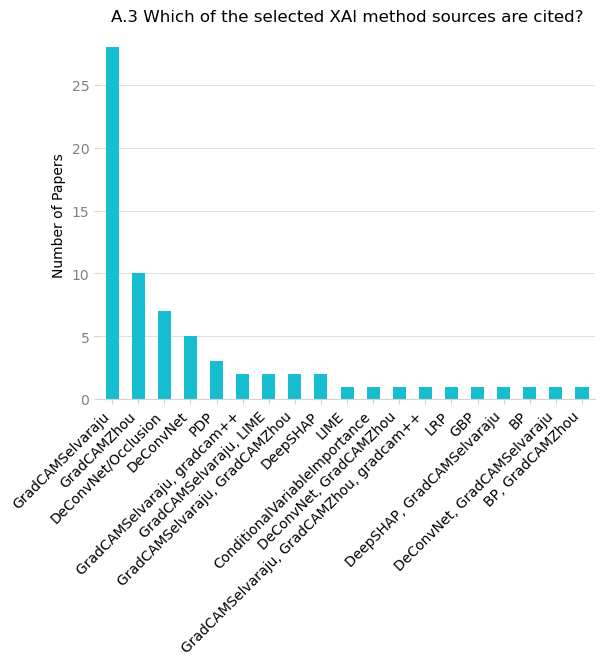

In [113]:
column_to_plot = "A.3 Which of the selected XAI method sources are cited?"

create_frequency_bar_plot(column_to_plot, df[column_to_plot].value_counts())

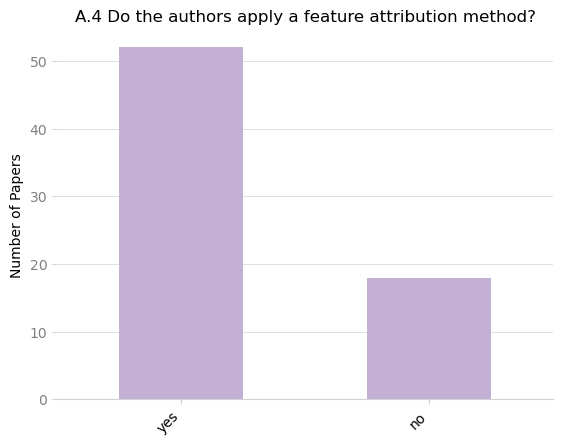

In [ ]:
column_to_plot = "A.4 Do the authors apply a feature attribution method?"

create_frequency_bar_plot(column_to_plot, df_xai_applied[column_to_plot].value_counts())

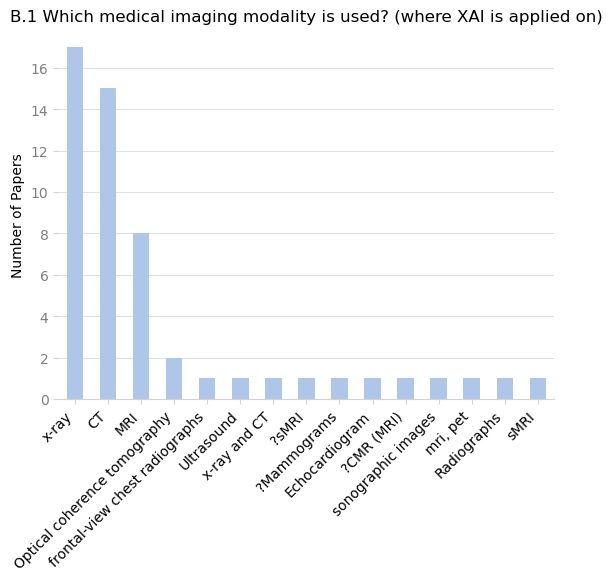

In [87]:
column_to_plot = "B.1 Which medical imaging modality is used? (where XAI is applied on)"

create_frequency_bar_plot(column_to_plot, df[column_to_plot].value_counts())

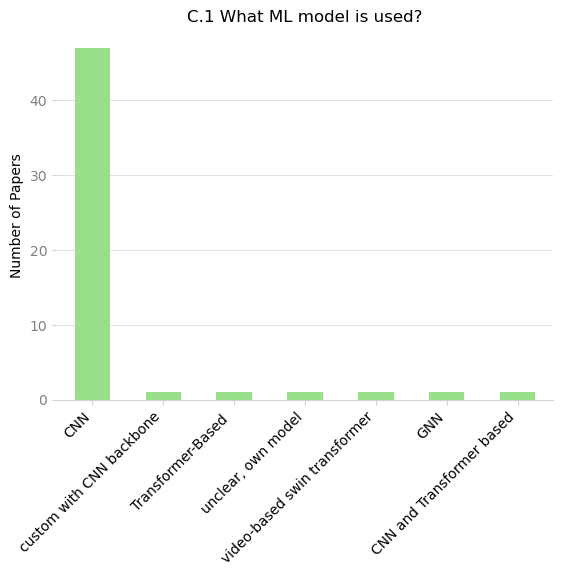

In [88]:
column_to_plot = "C.1 What ML model is used?"

create_frequency_bar_plot(column_to_plot, df[column_to_plot].value_counts())

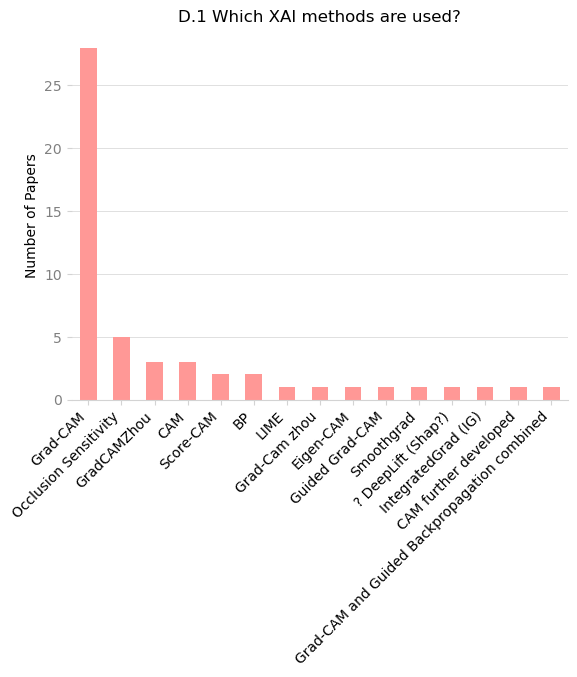

In [114]:
column_to_plot = "D.1 Which XAI methods are used?"

create_frequency_bar_plot(column_to_plot, df_xai_applied[column_to_plot].value_counts())


In [90]:
df_full_paper_list = pd.read_excel("/mnt/c/Users/Charlotte/Nextcloud2/Uni/Masterarbeit/Fulltext screening/dataExtractionForm_v2.3_2025-11-11.xlsx", sheet_name="Full cited-by list")

In [91]:
# Papers to years

#  PLOT Map paper to their years

# PLOT Map paper to their citation numbers

### XAI Application presentation


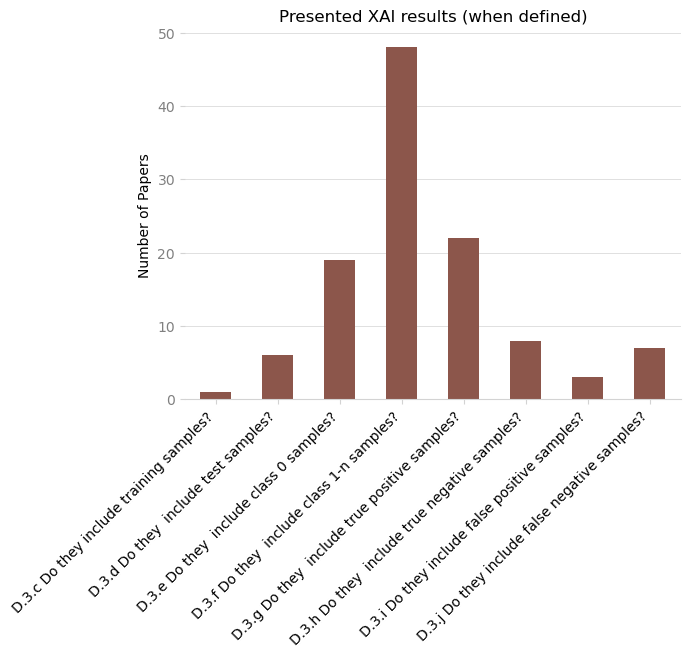

In [ ]:
columns_to_plot = [
       'D.3.c Do they include training samples?',
       'D.3.d Do they  include test samples?',
       'D.3.e Do they  include class 0 samples?',
       'D.3.f Do they  include class 1-n samples?',
       'D.3.g Do they  include true positive samples?',
       'D.3.h Do they  include true negative samples?',
       'D.3.i Do they include false positive samples?',
       'D.3.j Do they include false negative samples?',]

valid_counts = {}
for column in columns_to_plot:
      valid_counts[column] = df_xai_applied[column][df_xai_applied[column] == "yes"].count()

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts)

title = 'Presented XAI results (when defined)'

create_frequency_bar_plot(title, valid_counts_df)

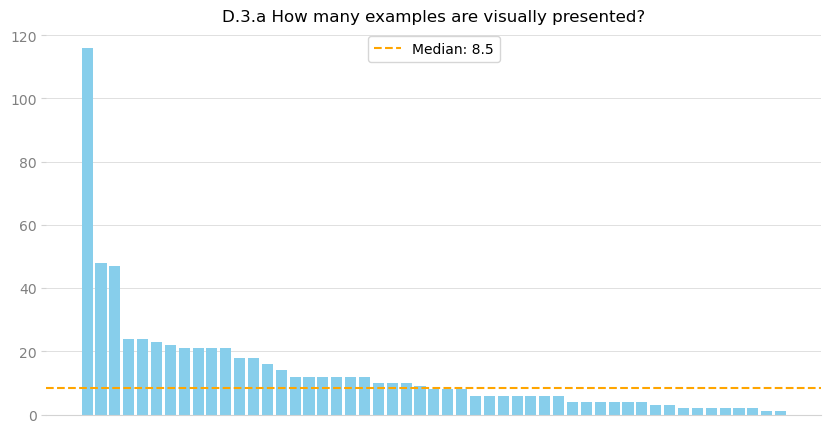

In [131]:
# Number of presented results
column_to_plot = 'D.3.a How many examples are visually presented?'

# Werte absteigend sortieren
sorted_values = df_xai_applied[column_to_plot].sort_values(ascending=False)

# Median berechnen
median_value = np.median(sorted_values)

# Plot erstellen
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(len(sorted_values)), sorted_values, color='skyblue')

# Horizontale Median-Linie hinzufügen
ax.axhline(y=median_value, color='orange', linestyle='--', label=f'Median: {median_value:.1f}')

# Beschriftungen und Titel
ax.set_xticks([])  # X-Achse unbeschriftet
ax.set_title(column_to_plot)

# Customize the axis lines
ax.spines['top'].set_visible(False)    # Hide top spine
ax.spines['right'].set_visible(False)  # Hide right spine
ax.spines['bottom'].set_color('lightgrey') # Set bottom (x-axis) to grey
ax.spines['left'].set_visible(False)   # Hide left (y-axis)
ax.tick_params(axis='x', colors='lightgrey')
ax.tick_params(axis='y', colors='lightgrey')
for label in ax.get_xticklabels():
    label.set_color('black')  # x-axis tick labels
for label in ax.get_yticklabels():
    label.set_color('grey')  # x-axis tick labels

# Add horizontal grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color='lightgrey')
ax.legend()


# Create plot file name from column name
file_name = title.replace(" ", "_")
file_name = file_name.replace("?", "")

# Save the plot as an image file
timestamp = datetime.now().strftime("%Y-%m-%d-%H%M")
plt.savefig("DEF_stats/" + file_name + timestamp + ".png", format='png', dpi=200, bbox_inches='tight')

### Claims


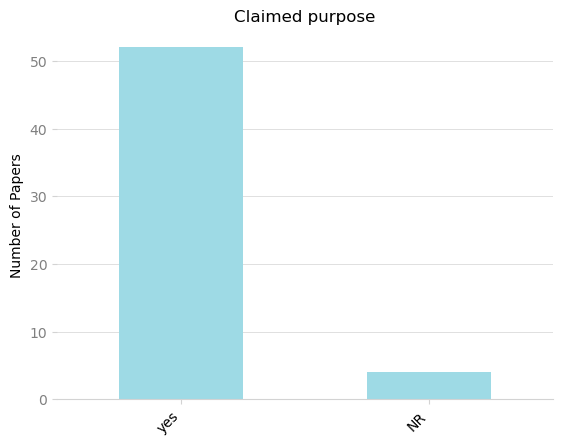

In [ ]:
# Basic overview 
column_to_plot = "E.1 Are purposes of using XAI methods claimed?"

create_frequency_bar_plot(column_to_plot, df_xai_applied[column_to_plot].value_counts())

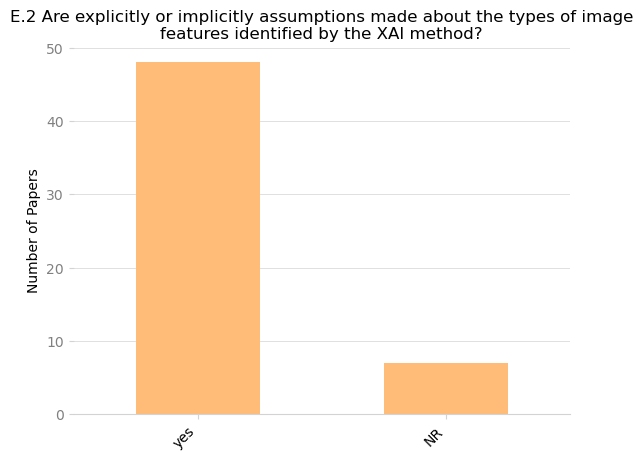

In [ ]:
column_to_plot = "E.2 Are explicitly or implicitly assumptions made about the types of image features identified by the XAI method?"

create_frequency_bar_plot(column_to_plot, df_xai_applied[column_to_plot].value_counts())

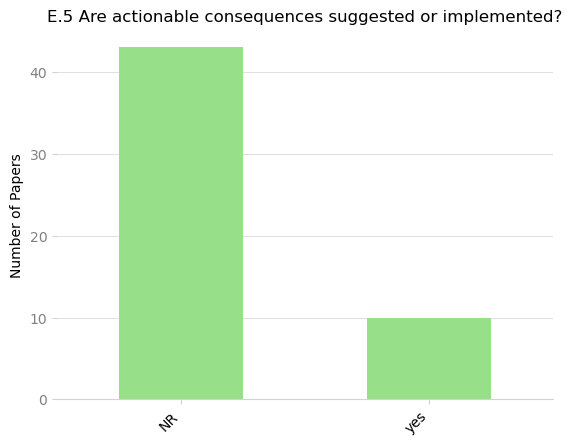

In [ ]:
column_to_plot = "E.5 Are actionable consequences suggested or implemented?"

create_frequency_bar_plot(column_to_plot, df_xai_applied[column_to_plot].value_counts())

In [ ]:
def create_frequency_bar_claims(df, columns_to_plot):
    # Zähle die gültigen Einträge
    valid_counts = {}
    for column in columns_to_plot:
        valid_counts[column] = df[column][(df[column] != 'NR') & (df[column] != 'N/A') & (~df[column].isna())].count()

    # Erstelle den Balkenplot
    valid_counts_df = pd.Series(valid_counts)
    valid_counts_df.plot(kind='bar', color=['blue', 'green', 'red'])
    plt.title('Number of entries not NR, N/A, or missing')
    plt.ylabel('Number of Papers')
    plt.xlabel('Spalten')
    plt.show()

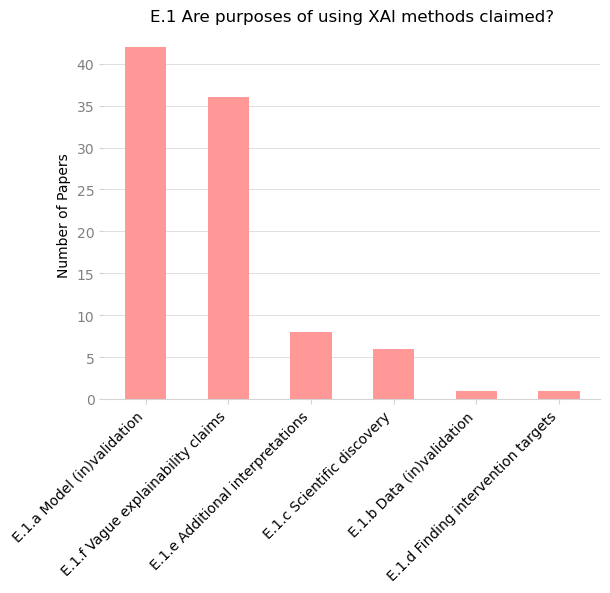

In [132]:
# E1 Purposes

columns_to_plot = [
       'E.1.a Model (in)validation', 'E.1.b Data (in)validation',
       'E.1.c Scientific discovery', 'E.1.d Finding intervention targets',
       'E.1.e Additional interpretations', 'E.1.f Vague explainability claims']

valid_counts = {}
for column in columns_to_plot:
      valid_counts[column] = df_xai_applied[column][(df_xai_applied[column] != 'NR') & (df_xai_applied[column] != 'N/A') & (~df_xai_applied[column].isna())].count()

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts).sort_values(ascending=False)

title = 'E.1 Are purposes of using XAI methods claimed?'
create_frequency_bar_plot(title, valid_counts_df)

In [98]:
# Check data (if it contains still a NR but with a space e.g.)
column = columns_for_purposes[5]
test = df[column][(df[column] != 'NR') & (df[column] != 'N/A') & (~df[column].isna())]

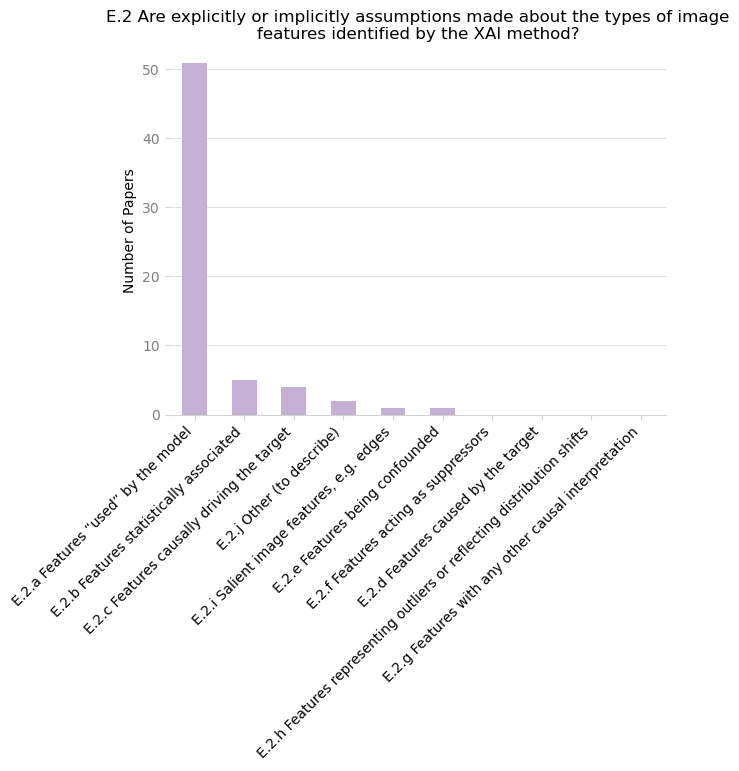

In [ ]:
# E2 Feature assumptions

columns_to_plot = [
       'E.2.a Features “used” by the model',
       'E.2.b Features statistically associated',
       'E.2.c Features causally driving the target',
       'E.2.d Features caused by the target',
       'E.2.e Features being confounded',
       'E.2.f Features acting as suppressors',
       'E.2.g Features with any other causal interpretation',
       'E.2.h Features representing outliers or reflecting distribution shifts',
       'E.2.i Salient image features, e.g. edges', 'E.2.j Other (to describe)']

valid_counts = {}
for column in columns_to_plot:
      valid_counts[column] = df_xai_applied[column][(df_xai_applied[column] != 'NR') & (df_xai_applied[column] != 'N/A') & (~df_xai_applied[column].isna())].count()

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts).sort_values(ascending=False)

title = 'E.2 Are explicitly or implicitly assumptions made about the types of image features identified by the XAI method?'

create_frequency_bar_plot(title, valid_counts_df)

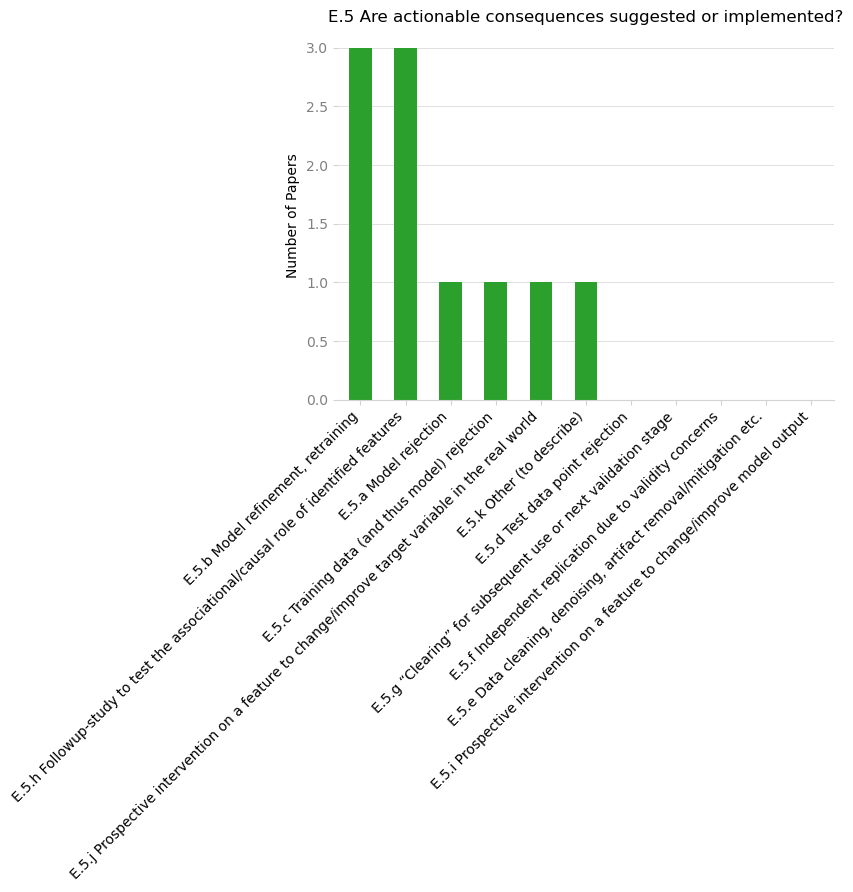

In [ ]:
# E3 Consequences

columns_to_plot = [
       'E.5.a Model rejection', 'E.5.b Model refinement, retraining',
       'E.5.c Training data (and thus model) rejection',
       'E.5.d Test data point rejection',
       'E.5.e Data cleaning, denoising, artifact removal/mitigation etc.',
       'E.5.f Independent replication due to validity concerns',
       'E.5.g “Clearing” for subsequent use or next validation stage',
       'E.5.h Followup-study to test the associational/causal role of identified features',
       'E.5.i Prospective intervention on a feature to change/improve model output',
       'E.5.j Prospective intervention on a feature to change/improve target variable in the real world',
       'E.5.k Other (to describe)']

valid_counts = {}
for column in columns_to_plot:
      valid_counts[column] = df_xai_applied[column][(df_xai_applied[column] != 'NR') & (df_xai_applied[column] != 'N/A') & (~df_xai_applied[column].isna())].count()

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts).sort_values(ascending=False)

title = 'E.5 Are actionable consequences suggested or implemented?'

create_frequency_bar_plot(title, valid_counts_df)